In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train(energy).csv', 'train.csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'sle', 'shc', 'she', 'case', 'duty', 'Rate_m3', 'Rate_ton'])

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train(energy).csv',index_col=0).dropna(axis=0)
print(df.shape)
df.head()

(16499, 67)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,Naphtha Properties_n-Tridecane_wt%,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Light End Product Properties_Light End Prod. Rate_m3/hr,Heart Cut Product Properties_Heart Cut Prod. Rate_m3/hr,Heavy End Product Properties_Heavy End Product Rate_m3/hr,Light End Product Properties_Light End Prod. Rate_ton/hr,Heart Cut Product Properties_Heart Cut Prod. Rate_ton/hr,Heavy End Product Properties_Heavy End Product Rate_ton/hr
001-01,10.0,100.0,2.5,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.0,2.280675,3.891577,4.252277,7.997900,100.000198,10.001979,5.469008,73.401711,7.604384
001-02,10.0,100.0,5.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.0,2.280843,3.723144,4.071568,8.445992,100.000122,9.553886,5.797086,73.411102,7.266858
001-03,10.0,100.0,10.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.0,2.280798,3.572479,3.900158,9.143384,100.000008,8.856608,6.294930,73.435539,6.744582
001-04,10.0,100.0,2.5,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.0,2.280843,3.442118,3.759819,7.284074,100.000275,10.715655,4.978351,73.360406,8.136289
001-05,10.0,100.0,5.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.0,2.280675,3.301176,3.607212,7.697134,99.999817,10.303131,5.280904,73.370414,7.823788


# calculate density

In [5]:
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['LE_density','HC_density','HE_density'],index=df.index)
density.head()

,LE_density,HC_density,HE_density
001-01,0.683806,0.734016,0.760288
001-02,0.686371,0.734110,0.760618
001-03,0.688468,0.734355,0.761531
001-04,0.683457,0.733602,0.759290
001-05,0.686087,0.733705,0.759360


# duty

In [6]:
duty = df[col_names['duty']]
duty = duty.drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
duty.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr
001-01,2.280675,4.252277
001-02,2.280843,4.071568
001-03,2.280798,3.900158
001-04,2.280843,3.759819
001-05,2.280675,3.607212


# define X,Y

In [8]:
X = df[col_names['case']].join(df[col_names['xna']])
print(X.shape)
X.head()

(16499, 58)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,10.0,100.0,2.5,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-02,10.0,100.0,5.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-03,10.0,100.0,10.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-04,10.0,100.0,2.5,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-05,10.0,100.0,5.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0


In [7]:
Y = duty.join(density)
print(Y.shape)
Y.head()

(16499, 5)


,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,LE_density,HC_density,HE_density
001-01,2.280675,4.252277,0.683806,0.734016,0.760288
001-02,2.280843,4.071568,0.686371,0.734110,0.760618
001-03,2.280798,3.900158,0.688468,0.734355,0.761531
001-04,2.280843,3.759819,0.683457,0.733602,0.759290
001-05,2.280675,3.607212,0.686087,0.733705,0.759360


# build scale

In [9]:
mm = MinMaxScaler()

# scale features

In [10]:
X[:] = mm.fit_transform(X[:])
X.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,0.0,0.5,0.000000,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-02,0.0,0.5,0.333333,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-03,0.0,0.5,1.000000,0.332220,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-04,0.0,0.5,0.000000,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0
001-05,0.0,0.5,0.333333,0.499165,0.0,0.0,0.0,0.014084,0.0106,0.010208,...,0.336071,0.336166,0.090949,0.282495,0.149402,0.282239,0.150533,0.080034,0.148144,0.0


# split train test

In [11]:
x_col = X.columns.tolist()
y_col = Y.columns.tolist()
df = shuffle(X.join(Y))

In [12]:
X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(13199, 58) (1650, 58) (1650, 58)
(13199, 5) (1650, 5) (1650, 5)


# to torch tensor

In [13]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float).cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float).cuda()

# data iter

In [14]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [15]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [16]:
class energy_net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(energy_net,self).__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,output_shape)
        self.act_fn = Tanh()
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        return x

In [17]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [18]:
net = energy_net(len(x_col),len(y_col)).cuda()
net.apply(init_weights)

energy_net(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (act_fn): Tanh()
)

# forward test

In [19]:
net(X_test)

tensor([[ 0.3795, -0.0325, -0.3303, -0.5656, -0.3933],
        [ 0.0537, -0.1028, -0.3143, -0.4098, -0.2412],
        [ 0.3544, -0.1148,  0.0712, -0.5077, -0.1499],
        ...,
        [ 0.2470, -0.3709, -0.1300, -0.3138, -0.3623],
        [ 0.4103,  0.0355, -0.0770, -0.4348, -0.2367],
        [ 0.2407, -0.4552,  0.1298, -0.4157,  0.4261]], device='cuda:0',
       grad_fn=<AddmmBackward>)

# torchviz

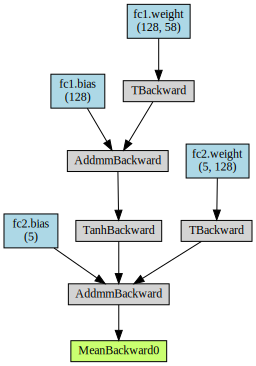

In [20]:
y = net(X_test)
torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))

# loss_function and optimizer

In [21]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [22]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 1.0436 valid loss 0.2304
record net
epochs 1 train loss 0.2126 valid loss 0.1969
record net
epochs 2 train loss 0.1864 valid loss 0.1797
record net
epochs 3 train loss 0.1693 valid loss 0.1604
record net
epochs 4 train loss 0.1557 valid loss 0.1501
record net
epochs 5 train loss 0.1444 valid loss 0.1363
record net
epochs 6 train loss 0.1341 valid loss 0.1298
record net
epochs 7 train loss 0.1247 valid loss 0.1153
record net
epochs 8 train loss 0.1155 valid loss 0.1067
record net
epochs 9 train loss 0.1065 valid loss 0.1008
record net
epochs 10 train loss 0.0976 valid loss 0.0930
record net
epochs 11 train loss 0.0900 valid loss 0.0823
record net
epochs 12 train loss 0.0834 valid loss 0.0801
record net
epochs 13 train loss 0.0779 valid loss 0.0742
record net
epochs 14 train loss 0.0738 valid loss 0.0722
record net
epochs 15 train loss 0.0711 valid loss 0.0660
record net
epochs 16 train loss 0.0688 valid loss 0.0644
record net
epochs 17 train loss 0.0674 valid loss 0.

epochs 159 train loss 0.0160 valid loss 0.0184
epochs 160 train loss 0.0159 valid loss 0.0179
record net
epochs 161 train loss 0.0154 valid loss 0.0193
epochs 162 train loss 0.0155 valid loss 0.0178
record net
epochs 163 train loss 0.0155 valid loss 0.0204
epochs 164 train loss 0.0157 valid loss 0.0178
record net
epochs 165 train loss 0.0152 valid loss 0.0169
record net
epochs 166 train loss 0.0154 valid loss 0.0183
epochs 167 train loss 0.0150 valid loss 0.0167
record net
epochs 168 train loss 0.0151 valid loss 0.0190
epochs 169 train loss 0.0151 valid loss 0.0197
epochs 170 train loss 0.0151 valid loss 0.0168
epochs 171 train loss 0.0151 valid loss 0.0187
epochs 172 train loss 0.0148 valid loss 0.0160
record net
epochs 173 train loss 0.0147 valid loss 0.0170
epochs 174 train loss 0.0148 valid loss 0.0179
epochs 175 train loss 0.0148 valid loss 0.0175
epochs 176 train loss 0.0146 valid loss 0.0174
epochs 177 train loss 0.0147 valid loss 0.0188
epochs 178 train loss 0.0145 valid loss 0

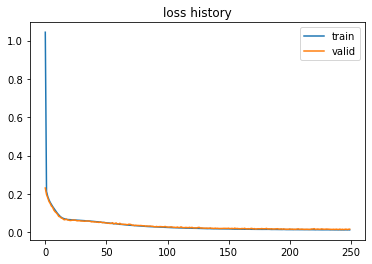

In [23]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [24]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,LE_density,HC_density,HE_density
0,2.302474,3.327610,0.697158,0.732864,0.757726
1,2.275292,4.596325,0.695638,0.747182,0.766195
2,2.419864,4.554056,0.679860,0.748750,0.772150
3,2.397243,3.479538,0.684173,0.753081,0.767764
4,2.192735,3.755720,0.695088,0.747703,0.766539


In [25]:
y_real = Y_test.cpu().detach().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,LE_density,HC_density,HE_density
0,2.281401,3.336113,0.702149,0.736726,0.761402
1,2.245486,4.423927,0.692199,0.742794,0.766884
2,2.383777,4.466335,0.683532,0.751644,0.774046
3,2.358350,3.452607,0.683678,0.754262,0.775950
4,2.168951,3.733348,0.697020,0.751944,0.771915


# metric

In [26]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.000860281,1.18564
Duty_Reboiler Heat Duty_Mkcal/hr,0.0836405,2.95835
LE_density,2.56127e-05,0.535119
HC_density,2.05157e-05,0.434741
HE_density,4.80523e-05,0.73574
AVG,0.016919,1.16992


# wrap model

In [27]:
class ANN_energy_wrapper(object):
    def __init__(self,x_col,y_col,scaler,net):
        self.x_col = x_col
        self.y_col = y_col
        self.scaler = scaler
        self.net = net
    
    def predict(self,x):
        x = self.scaler.transform(x)
        x = torch.tensor(x,dtype=torch.float).cuda()
        y = self.net(x).detach().cpu().numpy()
        y = pd.DataFrame(y,columns=self.y_col)
        return y

In [28]:
model = ANN_energy_wrapper(x_col,y_col,mm,net.eval())

# test ANN_wrapper

In [49]:
df = pd.read_csv(root+'train(energy).csv',index_col=0).sample(1000).dropna(axis=0)
x = df[x_col]
duty = df[col_names['duty']].drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['LE_density','HC_density','HE_density'],index=df.index)
y_real = duty.join(density)

In [50]:
x.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
080-23,30.0,100.0,5.0,1.5,0.0,0.0,0.0,0.025001,0.050003,0.417021,...,1.090055,2.543127,0.579029,0.695035,0.454023,0.131007,0.026001,0.002,0.005,0.0
194-01,10.0,100.0,2.5,1.0,0.0,0.0,0.0,0.048001,0.096002,0.799016,...,1.450029,3.385068,1.455029,1.516031,1.745035,0.287006,0.101002,0.005,0.020,0.0
115-26,30.0,100.0,5.0,2.0,0.0,0.0,0.0,0.077000,0.154000,1.280000,...,1.222000,2.852000,0.794000,0.850000,0.426000,0.161000,0.025000,0.003,0.005,0.0
283-16,20.0,100.0,2.5,0.5,0.0,0.0,0.0,0.000000,0.001000,0.007000,...,2.735027,6.382064,6.132061,0.762008,2.966030,0.144001,0.172002,0.003,0.033,0.0
214-03,10.0,100.0,10.0,1.0,0.0,0.0,0.0,0.046000,0.091999,0.766992,...,1.260988,2.942971,0.841992,0.904991,0.731993,0.170998,0.043000,0.003,0.008,0.0


# y_real

In [51]:
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,LE_density,HC_density,HE_density
080-23,2.313298,4.060829,0.685005,0.739680,0.761663
194-01,2.385708,4.605560,0.681839,0.755569,0.781520
115-26,2.388870,3.784140,0.672881,0.744615,0.765859
283-16,2.217990,3.555830,0.657680,0.758378,0.799069
214-03,2.403727,4.328571,0.685007,0.751751,0.771964


# y_pred

In [52]:
y_pred = model.predict(x)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,LE_density,HC_density,HE_density
0,2.341681,4.056776,0.686115,0.740915,0.757985
1,2.415441,4.615374,0.684426,0.759464,0.782031
2,2.424544,3.885087,0.673326,0.747292,0.763601
3,2.270612,3.751159,0.657263,0.764088,0.793653
4,2.438749,4.365391,0.687290,0.754204,0.769001


In [53]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.00085848,1.18572
Duty_Reboiler Heat Duty_Mkcal/hr,0.0507401,2.66411
LE_density,2.4037e-05,0.509408
HC_density,1.83348e-05,0.422502
HE_density,4.72777e-05,0.728501
AVG,0.0103376,1.10205


# save model

In [54]:
joblib.dump(model,'../model/ANN(energy).pkl')
print('save done!')

save done!
